In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [25]:
import pandas as pd
import datetime #para untilizarlo en 2. SeccionDataframe
#import os
import numpy as np
import itertools # para iterar las estrategias
import seaborn as sns
import mplfinance as mpf #prara grgaficar velas # https://github.com/matplotlib/mplfinance/tree/master/examples
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab # para ajustar el tamaño de los graficos
import warnings

warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = 20, 12 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('ggplot')
%matplotlib inline

In [26]:

def SeccionDataframe(data, ini_date, n_day):
    '''SeccionDataframe(data, ini_date, n_day)
        Crea DataFrame a partir del original con los datos a partir de una 
        fecha y un numero n de dias
        
        Parametros
        --------
        data: DataFrame, DataFrame original que queremos seccionar
        
        ini_date: str, fecha a partir de la que queremos comenzar
        
        n_day: int, numero de dias que queremos a partir de la fecha
        
        Returns
        --------
        DataFrame

            Se devuelve un DataFrame despues de filtrarlo
            
        Examples
        --------
        >>> SeccionDataframe('df, '2017-10-22', 30)'''
    
    date_time_obj = datetime.datetime.strptime(ini_date, '%Y-%m-%d')

    start = pd.to_datetime(date_time_obj.date())

    end_date = start + datetime.timedelta(days = n_day)
    
    # filtro: muestra los valores entre la fecha inicial y la final
    mask = (data.index > ini_date) & (data.index <= end_date)

    return data.loc[mask]

def VWMA_BB_restart_diario(data, std1, std2):
    '''Funcion que calcula la vwma en periodo diario, expandiendose +1 con cada vela que pasa, y sus 2 bandas de bollinguer, asociadas a 2 
    desviaciones estandar determinadas en la funcion como std1 y std2'''
    
    
    rolling_vwma = data.eval('wgtd = Close * Volume', inplace=False).groupby(data.index.date).cumsum().eval('wgtd / Volume')
    
    rolling_std = (rolling_vwma.groupby(data.index.date).expanding()).std().droplevel(0)
        
    data['VWMA Rolling'] = rolling_vwma
    data['VWMA_BB High 1'] = rolling_vwma + (rolling_std * std1)
    data['VWMA_BB Low 1'] = rolling_vwma - (rolling_std * std1)
    data['VWMA_BB High 2'] = rolling_vwma + (rolling_std * std2)
    data['VWMA_BB Low 2'] = rolling_vwma - (rolling_std * std2)
    
    return data

def estrategia_prueba_1_01 (df, x1, y1, x2, y2):
    '''Funcion del algoritmo de la estrategia. SL= Tamano de stop lost
                                                SD1= desviacion estandar
                                                x= angulo de incluinacion de la vwma a partir del cual si es menor efectua estrategia lateral
                                                y= Ratio Riesgo beneficio en funcion del SL
                                                z= distancia sumada a x, a partir de la cual tomara como estrategia tendencial'''
    
    
    def resultado_estrategia (estr1, parametros):
        '''Analisis de la rentabilidad del algoritmo principal'''
        resultados = parametros 
        resultados['Beneficio Bruto'] = round(estr1['Resultados acumulados'][-1],2)*50 


        resultados['Máximo Drawdown'] = round((estr1['Resultados acumulados'].div(estr1['Resultados acumulados'].cummax()).sub(1)).min(),2)
                                        
        resultados['Número de trades'] = len(estr1.Resultados[estr1.Resultados!=0])


        resultados['Num Trades Ganadores'] = estr1.loc[estr1.Resultados>0,'Resultados'].count()
        resultados['Num Trades Perdedores'] = estr1.loc[estr1.Resultados<0,'Resultados'].count()
        resultados['Ratio Acierto'] = round(100 * resultados['Num Trades Ganadores'] / resultados['Número de trades'], 2)


        return resultados

    
    
    
    estr = df.copy()
    estr1 = VWMA_BB_restart_diario(estr, 1.8 ,1.8)
    SL=5
    TP = 20
    com = 0.08 #comisiones
    
        # 0 Open    5 VWMA Rolling      10 Estado                
        # 1 High   6 VWMA_BB High 1    11 Precioapertura
        # 2 Low   7 VWMA_BB Low 1     12 Resultados
        # 3 Close    8 VWMA_BB High      13 Restuldos acumula
        # 4 Volume  9 VWMA_BB Low 2    14 tendencia
      
        
    #Esto crea las columnas con determinado valor en todas ellas
    (estr1['Estado'], estr1['Precio apertura operacion'], estr1['Resultados'], estr1['Resultados acumulados'], estr1['tendencia']) = 0, 0, 0, 100, None
    #redefinimos los valores que han de tener en cada una de ellas
    estr1['Resultados'] = pd.to_numeric(estr1['Resultados'], downcast='float')
    estr1['Resultados acumulados'] = pd.to_numeric(estr1['Resultados acumulados'], downcast='float')
    estr1['Precio apertura operacion'] = pd.to_numeric(estr1['Precio apertura operacion'], downcast='float')
    #Creamos contador de velas en el rango diario
    estr1['counter'] = 1
    estr1['counter1'] = estr1['counter'].groupby(estr1.index.date).cumsum()
    
    
    
    #Iteracion en cada una de las velas.
    for row in range(len(estr1)):
        c_tend_lateral = (abs(estr1.iat[row,5] - estr1.iat[row-4,5]) <= 0.5)#Condicion para definir tendencia lateral
        c_tend_tendencial = (abs(estr1.iat[row,5] - estr1.iat[row-4,5]) > 3.5)#Condicion para definir tendencia ascendente o descendente
        
#______________________________________________________________________LATERAL____________________________________________________________________

        if c_tend_lateral: #estrategia lateral
            #indicamos tendencia
            estr1.iat[row, 14] = 'lateral'
            #condiciones de apertura
            c_open_lwr_low1_vwma = ((estr1.Close.iloc[row-x1:row-y1].mean() < estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] <= estr1.iat[row-1, 7]))#Condicion compra: si precio close se encuentra por arriba de la media de los 3 ultimos closes & si el precio close esta por debajo o igual a la banda de bolinguer inferior
            c_open_bgr_high1_vwma = ((estr1.Close.iloc[row-x1:row-y1].mean() > estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] >= estr1.iat[row-1, 6]))#Condicion venta: si precio close se encuentra por debajo de la media de los 3 ultimos closes & si el precio close esta por arriba o igual a la banda de bolinguer inferior
            #COndiciones de cierre
            
            #grupo para misma vela
            c_low_lwr_prec_apert_op_sl1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - SL)
            c_low_lwr_prec_apert_op_tp1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - TP)
            c_hgh_bgr_prec_apert_op_tp1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + TP)
            c_hgh_bgr_prec_apert_op_sl1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + SL) 
            #grupo para velas consecutivas sin cerrar
            c_low_lwr_prec_apert_op_sl = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - SL)
            c_low_lwr_prec_apert_op_tp = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - TP)
            c_hgh_bgr_prec_apert_op_tp = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + TP)
            c_hgh_bgr_prec_apert_op_sl = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + SL)
            #Condicion de retraso en el dia de inicio de estrategia
            c_delay_diario = (estr1.iat[row, 16] >= 80)
        #----------------------------------------------------------------------------------------------------------------------------------------
            #Check para abrir operacion o seguir sin abrir
            if (estr1.iat[row-1, 10] == 0):
                if (c_open_bgr_high1_vwma)&(c_delay_diario):
                    estr1.iat[row, 10] = -1 
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                elif (c_open_lwr_low1_vwma)&(c_delay_diario):
                    estr1.iat[row, 10] = +1
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                else:
                    estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

            #Si abrimos y se cumple la condicion de cierre en una misma vela:
            if (estr1.iat[row-1, 10] == 0): 

                if (estr1.iat[row, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl1):
                        estr1.iat[row, 10]  = 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue


                if (estr1.iat[row, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue

            #si el cierre no se produce en la misma vela de apertura sino en las consecutivas:
            else:        

                if (estr1.iat[row-1, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]


                if (estr1.iat[row-1, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = -SL - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = TP - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                            estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                            estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                            estr1.iat[row, 13] = estr1.iat[row-1, 13]

#_________________________________________________________________Tendencial_____________________________________________________________________

        elif c_tend_tendencial:#estrategia tendencial

            estr1.iat[row, 14] = 'tendencial'
        
            c_open_hgr_low1_vwma_t = ((estr1.Close.iloc[row-x2:row-y2].mean() > estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] >= estr1.iat[row-1, 7]))
            c_open_lwr_high1_vwma_t = ((estr1.Close.iloc[row-x2:row-y2].mean() < estr1.iat[row-1, 3]) & (estr1.iat[row-1, 3] <= estr1.iat[row-1, 6]))
            
            c_low_lwr_prec_apert_op_sl1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - SL)
            c_low_lwr_prec_apert_op_tp1 = estr1.iat[row, 2] <= (estr1.iat[row-1, 3] - TP)
            c_hgh_bgr_prec_apert_op_tp1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + TP)
            c_hgh_bgr_prec_apert_op_sl1 = estr1.iat[row, 1] >= (estr1.iat[row-1, 3] + SL) 

            c_low_lwr_prec_apert_op_sl = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - SL)
            c_low_lwr_prec_apert_op_tp = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - TP)
            c_hgh_bgr_prec_apert_op_tp = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + TP)
            c_hgh_bgr_prec_apert_op_sl = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + SL)
            
            c_delay_diario = (estr1.iat[row, 16] >= 80)
            
            if (estr1.iat[row-1, 10] == 0):
                if (c_open_hgr_low1_vwma_t)&(c_delay_diario):
                    estr1.iat[row, 10] = -1 
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                elif (c_open_lwr_high1_vwma_t)&(c_delay_diario):
                    estr1.iat[row, 10] = +1
                    estr1.iat[row, 11] = estr1.iat[row-1, 3]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                else:
                    estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]
                    
                    
                    
            if (estr1.iat[row-1, 10] == 0): #todo esto es analisis en la misma fila 

                if (estr1.iat[row, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl1):
                        estr1.iat[row, 10]  = 0
                        estr1.iat[row, 12] = -SL - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue                            

                if (estr1.iat[row, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue
                               
            else:#analisis fila anterior        

                if (estr1.iat[row-1, 10] == 1):#estamos en compra
                               
                    if (c_low_lwr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                        estr1.iat[row, 12] = -SL - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]




                if (estr1.iat[row-1, 10] == -1):
                    if (c_hgh_bgr_prec_apert_op_sl).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = -SL - com
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = TP - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                            estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                            estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                            estr1.iat[row, 13] = estr1.iat[row-1, 13]      
                            
                            
#______________________SI NO ESTAMOS EN TENDENCIA LATERAL NI TENDENCIAL, solo cerramos operaciones ya abiertas, o transladamos info_________________________________

        else:   
            
            if (estr1.iat[row-1, 10] == 0):#no hay operacion abierta
                estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                estr1.iat[row, 13] = estr1.iat[row-1, 13]
                
                
            if (estr1.iat[row-1, 10] == 1):#estamos en compra

                if (c_low_lwr_prec_apert_op_sl).all():
                    estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                    estr1.iat[row, 12] = -SL - com 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                elif (c_hgh_bgr_prec_apert_op_tp).all():
                    estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                    estr1.iat[row, 12] = TP - com
                    estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                else:
                    estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                    estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]


            if (estr1.iat[row-1, 10] == -1):#estamos en venta
                if (c_hgh_bgr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                elif (c_low_lwr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]           
            

            
                       
    parametros = {'media11' : x1, 'media12' : y1, 'media21' : x2, 'media22' : y2}                         
    resultados = resultado_estrategia(estr, parametros)
    
    return estr1, resultados

In [27]:
#--------------------------------------------------------------------------
#  F O R M A T O   D E L   D A T A F R A M E   - -   R E D U C C I O N
#--------------------------------------------------------------------------
print('Preparando DataFrame....')

df = pd.read_csv('es-5m_fixed_vwap.csv', sep=';')
df['time']= pd.to_datetime(df['time'], format = '%d-%m-%Y %H:%M')
df = df.set_index(pd.DatetimeIndex(df['time']))
df= df.drop(['time'], axis=1)

# reduce numero de bytes para las columnas
df["Open"] = pd.to_numeric(df["Open"], downcast='float') 
df["Close"] = pd.to_numeric(df["Close"], downcast='float') 
df["High"] = pd.to_numeric(df["High"], downcast='float') 
df["Low"] = pd.to_numeric(df["Low"], downcast='float')  
df['Volume'] = pd.to_numeric(df['Volume'], downcast='float') 

#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#      M U E S T R A   G R A F I C A   D  E   L A   S E C C I O N 
#--------------------------------------------------------------------------
#df_btc_copy = df_btc.copy()
#df_btc_vwmabb_100_1_2 = VWMA_BB(df_btc_copy, 90, 0.5 ,1)

# Informacion para una linea con los valores de cierre de las acciones en
# la seccion elegida
#data_close_btc = mpf.make_addplot(df_btc_vwma_bb_20_2['Close'],color='yellow')

# Lineas de los valores obtenidos con la funcion BollingerBands
#bb_r_vwma = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA Rolling'],color='red')
#bb_high1 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB High 1'],color='green')
#bb_low1 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB Low 1'],color='green')
#bb_high2 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB High 2'],color='purple')
#bb_low2 = mpf.make_addplot(df_btc_vwmabb_100_1_2['VWMA_BB Low 2'],color='purple')

#indicadores = [bb_r_vwma, bb_high1, bb_low1, bb_high2, bb_low2]

#mpf.plot(df_btc_vwmabb_100_1_2, type = 'candle', 
##         figscale = 2
#        , volume = True, addplot = indicadores)
#--------------------------------------------------------------------------
#      I T E R A R   E S T R A T E G I A 
#--------------------------------------------------------------------------
#seccion de 30 dias del ES
df_btc = SeccionDataframe(df, '2019-04-01',365)
x1 =range(1,5)
y1 =range(1,5)
x2 =range(1,5)
y2 =range(1,5)



#26460


#coleccion = {}
resultados = {}
parametros = itertools.product(*[x1, y1, x2, y2])


for par in parametros:
    x1, y1, x2, y2 = par   
    if x2>=y2 | x1>=y1:
        continue

    
    estr1, resultado = estrategia_prueba_1_01 (df_btc, x1, y1, x2, y2)
    nombre = f'estrategia_{x1}_{y1}_{x2}_{y2}'
    #coleccion[nombre] = estr1
    resultados[nombre] = resultado
    print ('Realizados {} backtests sobre una serie de {} muestras'.format(len(resultados), df_btc.shape[0]))
    
    # HACE PRUEBAS CON EL NUMERO DE ITERACIONES QUE QUEREMOS
    #if len(coleccion) == 1:
        #break

Preparando DataFrame....


KeyboardInterrupt: 

In [19]:
#6517
clasificacion = pd.DataFrame(resultados).transpose()
clasificacion.to_excel('vwap prueba angulos ES.xls')
pd.DataFrame(clasificacion['Beneficio Bruto'].sort_values(ascending=False).head(10))

,Beneficio Bruto
estrategia_3_2_2_1,30282.000732
estrategia_4_2_2_1,28055.999756
estrategia_2_1_2_1,27722.000122
estrategia_4_2_4_3,26638.000488
estrategia_3_1_2_1,25496.000671
estrategia_3_2_2_2,25346.000671
estrategia_3_2_2_3,25346.000671
estrategia_3_2_2_4,25346.000671
estrategia_3_2_3_4,25346.000671
estrategia_3_2_4_4,25346.000671


In [31]:
df_btc1 = SeccionDataframe(df, '2016-04-01',1000)


In [32]:
pro = estrategia_prueba_1_01 (df_btc1, 3,2,2,1)

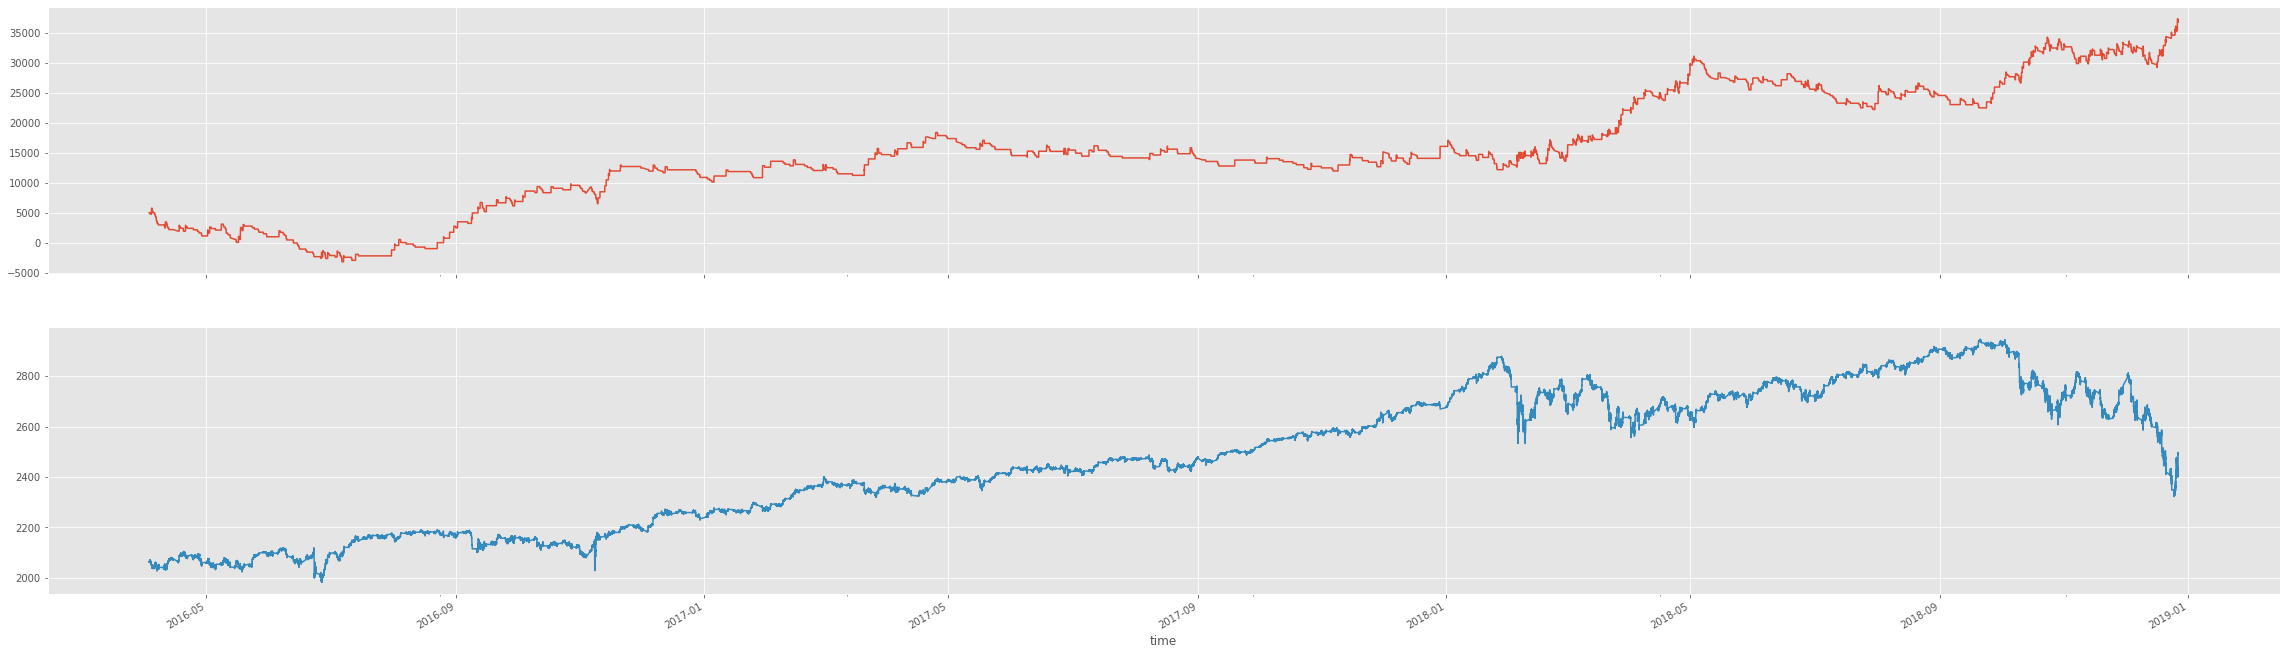

In [33]:
pro[0]['Resultados acumulados'] = pro[0]['Resultados acumulados']*50
pro[0][['Resultados acumulados','Open']].plot(subplots = True, grid = True, legend = False, figsize=(40, 12))

pro[0].to_excel('averaver1.xlsx')

In [23]:
pro = estrategia_prueba_1_01 (df_btc1, 2,1,2,1)

In [ ]:
pro[0]['Resultados acumulados'] = pro[0]['Resultados acumulados']*50
pro[0][['Resultados acumulados','Open']].plot(subplots = True, grid = True, legend = False, figsize=(40, 12))

pro[0].to_excel('averaver1.xlsx')